# Example 2: Signal debluring  

In [21]:
# To start this notebook with more than one thread run "export JULIA_NUM_THREADS=4" in the terminal 
# before starting the jupyter notebook

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())

6


In [22]:
# Import module. 
using Revise
using PriorNormalization

In [23]:
# Import packages 
using ApproxFun # for approximating gammainvccdf by a Chbychev interpolant
using CairoMakie # for plots 
using Dates # to measure computational time 
using JLD2 # for saving and loading results
using FlexiMaps # for log-range  
using LinearAlgebra # to represent the identity matrix as "I" 
using Printf # for specific output format
using Random # for generating random noise 
using Statistics  # for mean and quantile
using StatsBase # for defining customized distributions 
using StatsFuns # for defining customized distributions 
using StatsPlots # for plotting 
using SparseArrays # for efficient storing of the forward operator 
using SpecialFunctions
using Turing # for setting up the model and sampling 
using Optim # for ML and MAP estimation 
using Plots: Plots, plot, plot!, scatter, scatter!, savefig, surface, surface!
using ProgressMeter # to show progress 

## Signal deblurring problem: Define the data model 

In [24]:
# Number of equidistant grid points
N = 128 

# Select the model
model_nr = 4

# Sampler parameters 
init = "prior" # Initialization option: "MAP", "prior"
nr_samples_raw = 10^4 # Number of samples
thin = 10^0 # Thinning factor
nr_chains = 6 # number of MCMC chains 

# Define the piecewise constant signal. 
function signal(t; tt=[0.17, 0.39, 0.48, 0.73, 0.83], 
    dx = [1, -2.4, 2.8, -0.6, -0.8])
    x = 0
    Ij = findall(x -> x < t, tt)
    if !isempty(Ij)
        x = sum(dx[Ij])
    end
    
    return x
end

signal (generic function with 1 method)

In [25]:
# Invertible finite difference matrix
aux = ones(N) * [-1.0, 1.0]'
L = spzeros(Float64, N, N)
L[2:end,:] = spdiagm(0=>-1*ones(N), 1=>ones(N))[1:N-1,1:N]
L[1,1] = 1 

1

## Select the model

In [26]:
# Parameter of of generalized gamma hyper-prior 
r_range = [ 1.0, .5, -.5, -1.0 ]; 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ];
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ];

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

0.00012308

In [27]:
interval = -5..5
# Create an array of functions
if r > 0 
    Γinvccdf_cheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdf_cheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

Fun(Chebyshev(-5 .. 5), [4.1893, -6.76855, 3.39898, -0.818537, -0.068503, 0.0574292, 0.0200184, -0.00580982, -0.00554048, -0.000166345  …  -4.223e-10, -9.28847e-10, -2.06209e-10, 2.0424e-10, 1.39925e-10, -1.39843e-11, -4.54018e-11, -1.43472e-11, 1.03344e-11, 6.97238e-12])

## Load and illustrate the MAP estimates

In [28]:
# Load the MAP estimates 

# MAP estimate of the original posterior 
@load "data/deblurring_model$(model_nr)_MAP_original.jld2" θ_MAP z_MAP x_MAP
# Initialize an empty vector to store the interleaved values
original_MAP = Vector{Float64}(undef, 2N)
# Interleave τ_MAP and u_MAP
original_MAP[1:2:end] .= θ_MAP
original_MAP[2:2:end] .= z_MAP

128-element view(::Vector{Float64}, 2:2:256) with eltype Float64:
 -0.0011965020794867456
 -0.0012608933745197428
 -0.0013129124768013324
 -0.0013389086854464832
 -0.0013302495679842017
 -0.0012862136805278247
 -0.0012142143721296094
 -0.0011268393693264279
 -0.0010363481200603248
 -0.0009493406760427666
 -0.0008651668709887507
 -0.0007792695354696961
 -0.0006884867180628984
  ⋮
 -3.831828193092365e-5
 -1.8397760886669887e-5
 -1.4210163634596664e-5
 -2.5488874264808827e-5
 -4.802770105035047e-5
 -7.48378725664723e-5
 -9.798446293373433e-5
 -0.00011065660638756353
 -0.00010887010522492404
 -9.238258089012929e-5
 -6.464425966453202e-5
 -3.167391179858925e-5

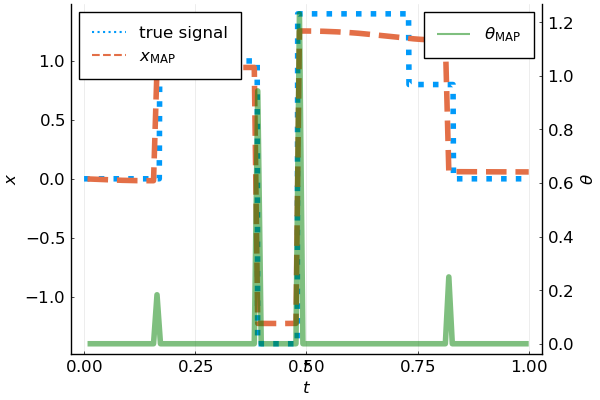

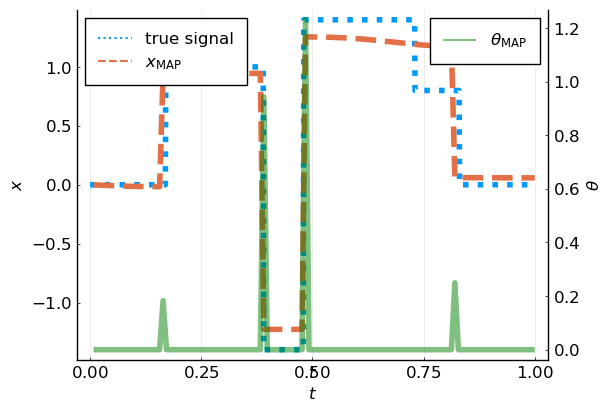

In [29]:
# Illustrate the MAP estimate of the target posterior
pyplot()

# create grid points and compute discrete signal values 
t_coarse = (1:N)/N 
t_range_aux = range(0, stop=1, length=1000)
signal_values = signal.(t_range_aux)
# compute increment values
increment_values = similar(signal_values)
increment_values[1] = 0
increment_values[2:end] = signal_values[2:end] .- signal_values[1:end-1]

# Initiate plot 
p1 = Plots.plot() 
p1_twin = twinx(p1)

# Create the plot 
Plots.plot!( p1, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot 
)
# Add MAP estimate for x 
Plots.plot!( p1, 
    t_coarse, x_MAP; 
    label=L"x_{\rm MAP}", 
    lw=4, ls=:dash
)

# Add MAP estimate for θ  
Plots.plot!( p1_twin,  
    t_coarse, θ_MAP; 
    label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p1,
    #ylim = [-1.75, 2.0],
    xlabel=L"t", ylabel=L"x", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Make some cosmetic changes to the plot 
Plots.plot!( p1_twin, 
    #ylim = [-4e-3, 0.4],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p1)

## Load and transform the samples

In [30]:
# Load the MCMC chains and compute duration from the JLD2 file
if init=="MAP"
    # Select the file names for loading the MCMC results 
    # Original model 
    filename_original = joinpath("data", 
        "deblurring_model$(model_nr)_mcmc_initMAP_Gibbs_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

# Use random prior samples 
elseif init=="prior"
    # Select the file names for saving the later MCMC results 
    # Original model 
    filename_original = joinpath("data", 
        "deblurring_model$(model_nr)_mcmc_initPrior_Gibbs_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )
    
# Throw an error if none of the available options is provided
else
    error("Invalid initialization option provided: $init. Please choose either 'MAP' or 'prior'.")
end

# Load the MCMC chains and compute duration from the JLD2 file
@load filename_original chn_original wall_duration_original

2-element Vector{Symbol}:
 :chn_original
 :wall_duration_original

### Tranform increments into signal values 

In [31]:
# Initialize an array to store the transformed x vectors

# Array to store the sample values
chn_values = similar(chn_original.value) 
nr_samples = size(chn_original.value, 1)
nr_chains = size(chn_original.value, 3)

# Change the parameter values 
# Transform each z vector to x
Threads.@threads for j in 1:nr_chains
    for i in 1:nr_samples
        # θ-parameters are the same 
        θ = chn_original.value[i, 1:2:end-1, j]
        chn_values[i, 1:2:end-1, j] = θ 
        # Transform z-parameters into x-parameters 
        z = chn_original.value[i, 2:2:end, j]
        x = L \ z
        chn_values[i, 2:2:end, j] = x
    end
end

# Change the parameter names 
# Extract the names of the parameters
parameter_names = names(chn_original)
# Convert parameter names from symbols to strings
parameter_names_str = string.(parameter_names)
# Rename z parameters to x
signal_names_str = replace.(parameter_names_str, "z" => "x")
# Convert parameter names back to symbols
signal_names = Symbol.(signal_names_str)

# Convert the transformed array back to a Chains object with updated parameter names
chn_signal = Chains(chn_values, signal_names); 

# Free the memory occupied by chn_values
chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

## Illustrate UQ for the original samples

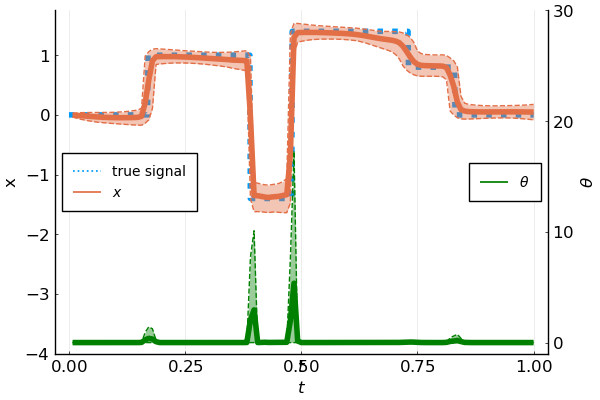

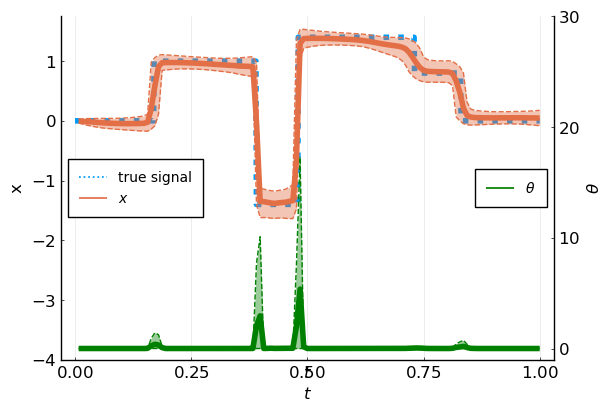

In [32]:
# Illustrate the mean and quantiles of x and θ

# Compute the pointwise mean and 90% quantile range of the x-samples
x_mean = [mean( get(chn_signal, :x).x[i] ) for i in 1:N]
x_lower_quantile = [quantile( vec(get(chn_signal, :x).x[i]), 0.05 ) for i in 1:N]  # 5% quantile
x_upper_quantile = [quantile( vec(get(chn_signal, :x).x[i]), 0.95 ) for i in 1:N]  # 95% quantile

# Compute the pointwise mean and 90% quantile range of the θ-samples
θ_mean = [mean( get(chn_signal, :θ).θ[i] ) for i in 1:N]
θ_lower_quantile = [quantile( vec(get(chn_signal, :θ).θ[i]), 0.05 ) for i in 1:N]  # 5% quantile
θ_upper_quantile = [quantile( vec(get(chn_signal, :θ).θ[i]), 0.95 ) for i in 1:N]  # 95% quantile

pyplot() 

# Initiate the plots 
p = plot() 
p_twin = twinx(p) 

# Plot the true signal 
plot!( p, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot  
)

# Add the pointwise mean for x 
plot!(p, 
    t_coarse, x_mean, 
    label=L"x", lw=4, ls=:solid 
)

# Add (invicible) lines for the lower and upper quantiles for x
plot!(p, 
    t_coarse, x_lower_quantile, 
    label=false, 
    lw=1, ls=:dash, color=2
)
plot!(p, 
    t_coarse, x_upper_quantile, 
    label=false, 
    lw=1, ls=:dash, color=2
)
# Add shaded region between the quantiles for x 
plot!(p, 
    t_coarse, x_lower_quantile, fillrange = x_upper_quantile, 
    label=false,
    fillalpha = 0.4, lw=0, color=2
)

# Make some cosmetic changes to the plot 
plot!( p, 
    ylim = [-4.0, 1.75],
    xlabel=L"t", ylabel="x", 
    tickfontsize=12, labelfontsize=12, legendfontsize=10, # font sizes 
    legend=:left,
)


# Add the pointwise mean for θ 
plot!(p_twin, 
    t_coarse, θ_mean, 
    label=L"\theta", 
    lw=4, ls=:solid, color=:green
)

# Add (invicible) lines for the lower and upper quantiles for x
plot!(p_twin, 
    t_coarse, θ_lower_quantile,
    label=false, 
    lw=1, ls=:dash, color=:green
)
plot!(p_twin, 
    t_coarse, θ_upper_quantile, 
    label=false,
    lw=1, ls=:dash, color=:green
)
# Add shaded region between the quantiles for x 
plot!(p_twin, 
    t_coarse, θ_lower_quantile, fillrange = θ_upper_quantile,
    label=false, 
    fillalpha = 0.4, lw=0, color=:green
)

# Make some cosmetic changes to the plot 
plot!( p_twin, 
    ylim = [-1e-0, 3*1e+1],
    ylabel=L"\theta",   
    tickfontsize=12, labelfontsize=12, legendfontsize=10, # font sizes
    legend=:right
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_UQquantile_original_Gibbs_$(init).pdf"
)
PyPlot.savefig(output_filename)

## Illustrate UQ for the individual chains of the original posterior

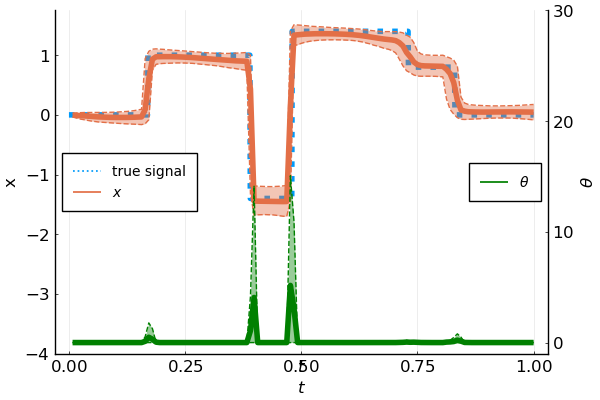

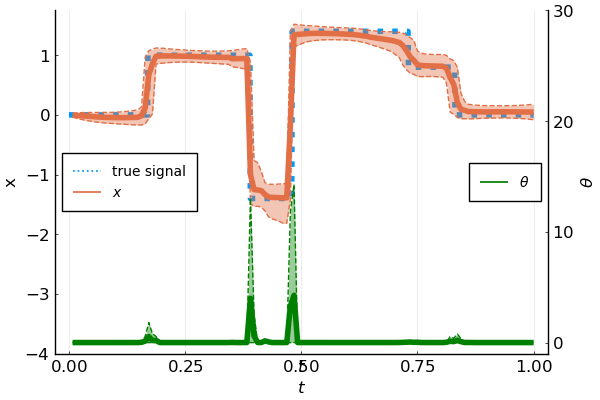

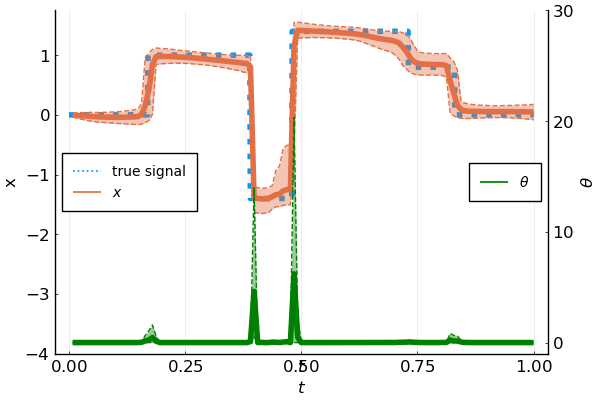

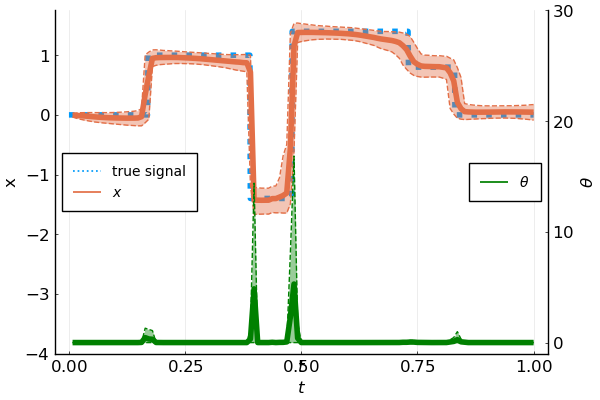

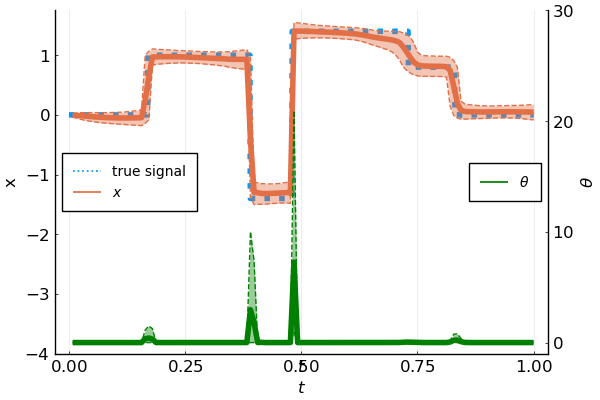

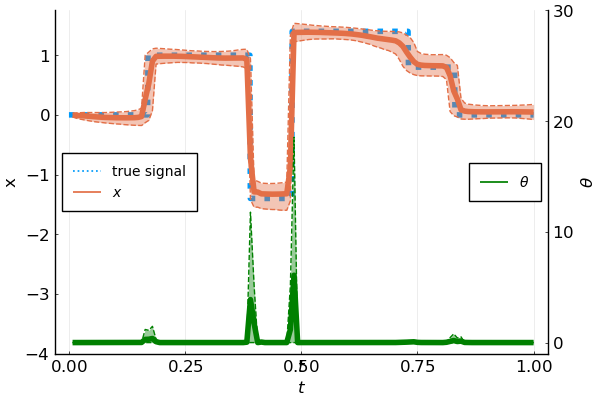

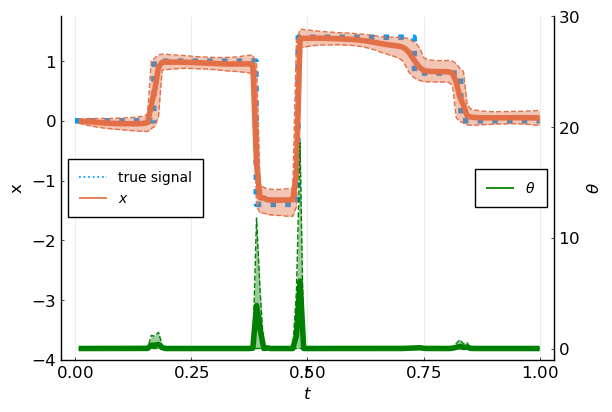

In [33]:
# Illustrate the mean and quantiles of x and θ

for j=1:nr_chains
    
    # Select the jth chain 
    chn = chn_signal[:, :, j]
    
    # Compute the pointwise mean and 90% quantile range of the x-samples
    x_mean = [mean( get(chn, :x).x[i] ) for i in 1:N]
    x_lower_quantile = [quantile( vec(get(chn, :x).x[i]), 0.05 ) for i in 1:N]  # 5% quantile
    x_upper_quantile = [quantile( vec(get(chn, :x).x[i]), 0.95 ) for i in 1:N]  # 95% quantile

    # Compute the pointwise mean and 90% quantile range of the θ-samples
    θ_mean = [mean( get(chn, :θ).θ[i] ) for i in 1:N]
    θ_lower_quantile = [quantile( vec(get(chn, :θ).θ[i]), 0.05 ) for i in 1:N]  # 5% quantile
    θ_upper_quantile = [quantile( vec(get(chn, :θ).θ[i]), 0.95 ) for i in 1:N]  # 95% quantile

    pyplot() 

    # Initiate the plots 
    p = plot() 
    p_twin = twinx(p) 

    # Plot the true signal 
    plot!( p, 
        t_range_aux, signal_values; 
        label="true signal", 
        lw=4, ls=:dot  
    )

    # Add the pointwise mean for x 
    plot!(p, 
        t_coarse, x_mean, 
        label=L"x", lw=4, ls=:solid 
    )

    # Add (invicible) lines for the lower and upper quantiles for x
    plot!(p, 
        t_coarse, x_lower_quantile, 
        label=false, 
        lw=1, ls=:dash, color=2
    )
    plot!(p, 
        t_coarse, x_upper_quantile, 
        label=false, 
        lw=1, ls=:dash, color=2
    )
    # Add shaded region between the quantiles for x 
    plot!(p, 
        t_coarse, x_lower_quantile, fillrange = x_upper_quantile, 
        label=false,
        fillalpha = 0.4, lw=0, color=2
    )

    # Make some cosmetic changes to the plot 
    plot!( p, 
        ylim = [-4.0, 1.75],
        xlabel=L"t", ylabel="x", 
        tickfontsize=12, labelfontsize=12, legendfontsize=10, # font sizes 
        legend=:left,
    )


    # Add the pointwise mean for θ 
    plot!(p_twin, 
        t_coarse, θ_mean, 
        label=L"\theta", 
        lw=4, ls=:solid, color=:green
    )

    # Add (invicible) lines for the lower and upper quantiles for x
    plot!(p_twin, 
        t_coarse, θ_lower_quantile,
        label=false, 
        lw=1, ls=:dash, color=:green
    )
    plot!(p_twin, 
        t_coarse, θ_upper_quantile, 
        label=false,
        lw=1, ls=:dash, color=:green
    )
    # Add shaded region between the quantiles for x 
    plot!(p_twin, 
        t_coarse, θ_lower_quantile, fillrange = θ_upper_quantile,
        label=false, 
        fillalpha = 0.4, lw=0, color=:green
    )

    # Make some cosmetic changes to the plot 
    plot!( p_twin, 
        ylim = [-1e-0, 3*1e+1],
        ylabel=L"\theta",   
        tickfontsize=12, labelfontsize=12, legendfontsize=10, # font sizes
        legend=:right
    )

    # Display the plot
    display(p)

    # Save the plot 
    script_directory = @__DIR__  # Gets the directory of the current script
    output_filename = joinpath(
        script_directory, 
        "figures", 
        "deblurring_model$(model_nr)_UQquantile_original_Gibbs_$(init)_chain$(j).pdf"
    )
    PyPlot.savefig(output_filename)
    
end

## Plot different samples from original posterior

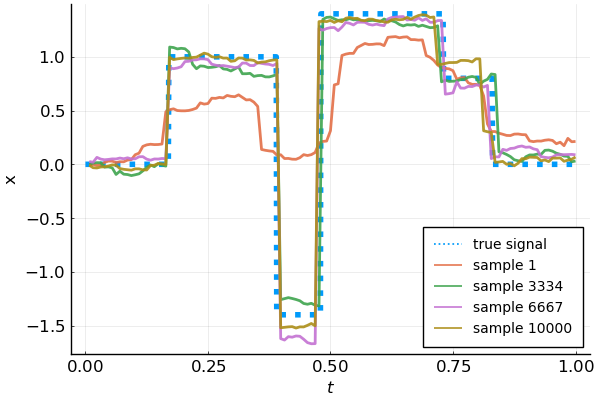

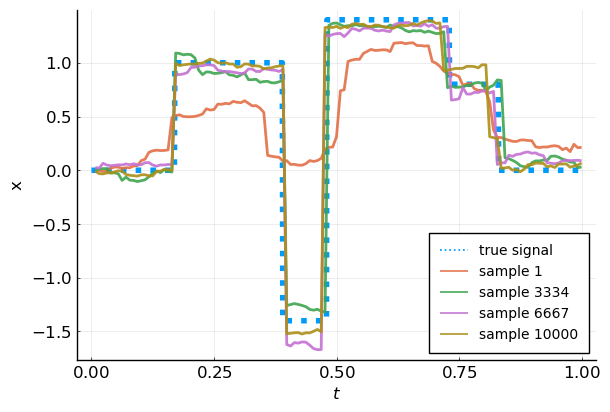

In [34]:
# Select sub-chains 
nr_draws = 4 
I_all = size(chn_signal, 1)
I_half = Int64(ceil(I_all/2))
selected_indices = collect(Int64.(range(1, I_all, length=nr_draws))) 

pyplot()

# Initiate the plots 
p = plot() 

# Plot the true signal 
plot!( p, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot 
)

# Plot 10 equidistant samples/realizations for θ
for i in 1:nr_draws
    chn_selected = chn_signal[selected_indices[i], :, 1]
    x_samples = [mean( get(chn_selected, :x).x[i] ) for i in 1:N]
    plot!(p, 
        t_coarse, x_samples, 
        label="sample $(selected_indices[i])", 
        lw=2, ls=:solid, alpha=.9
    )
end

# Make some cosmetic changes to the plot 
plot!( p, 
    #ylim = [-3.5, 1.75],
    xlabel=L"t", ylabel="x", 
    tickfontsize=12, labelfontsize=12, legendfontsize=10, # font sizes 
    legend=:bottomright
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_xSamples_original_Gibbs_$(init).pdf"
)
PyPlot.savefig(output_filename)

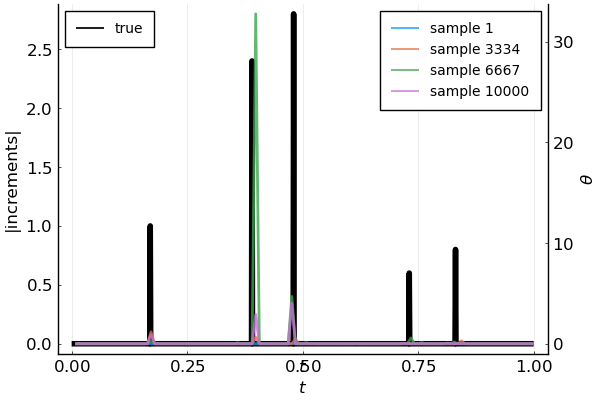

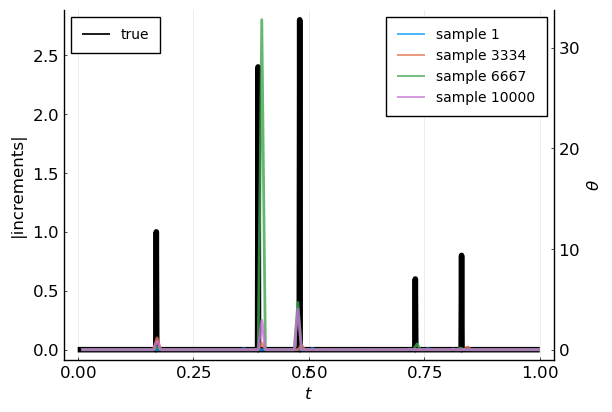

In [35]:
# Select sub-chains 
nr_draws = 4 
I_all = size(chn_original, 1)
I_half = Int64(ceil(I_all/2))
selected_indices = collect(Int64.(range(1, I_all, length=nr_draws))) 

pyplot()

# Initiate the plots 
p = plot() 
p_twin = twinx(p)  

# Plot the true signal 
plot!( p, 
    t_range_aux, abs.(increment_values); 
    label="true", 
    lw=4, ls=:solid, color=:black  
)

# Make some cosmetic changes to the plot 
plot!( p, 
    #ylim = [-3.5, 1.75],
    xlabel=L"t", ylabel="|increments|", 
    tickfontsize=12, labelfontsize=12, legendfontsize=10, # font sizes 
    legend=:topleft
)

# Plot 10 equidistant samples/realizations for θ
for i in 1:nr_draws
    chn_selected = chn_signal[selected_indices[i], :, 1]
    θ_samples = [mean( get(chn_selected, :θ).θ[i] ) for i in 1:N]
    plot!(p_twin, 
        t_coarse, θ_samples, 
        label="sample $(selected_indices[i])", 
        lw=2, ls=:solid, alpha=.8
    )
end

# Make some cosmetic changes to the plot 
plot!( p_twin, 
    #ylim = [0,.6],
    ylabel=L"\theta",   
    tickfontsize=12, labelfontsize=12, legendfontsize=10, # font sizes
    legend=:topright
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_thetaSamples_original_Gibbs_$(init).pdf"
)
PyPlot.savefig(output_filename)

## Traces for two specific locations

We focus on investigating  $(x[j],\theta[j])$ for $j=10$ and $j=22$.
Note that $t[j] \approx 0.08$ and $x_{\rm true}[j] = 0$ for $j=10$, which lies in a constant region. 
Furthermore, $t[j] \approx 0.172$ and $x_{\rm true}[j] = 1$ for $j=22$, which is close to the first jump discontinuity.

In [36]:
# Extract samples from the original and prior-normalized posterior 

# Fix indices 
j1 = 10 # index for first index 
j2 = 22 # index for second location

x_original_j1 = get(chn_signal, :x).x[j1];
θ_original_j1 = get(chn_signal, :θ).θ[j1];
x_original_j2 = get(chn_signal, :x).x[j2];
θ_original_j2 = get(chn_signal, :θ).θ[j2];

# Select sub-chains 
I_all = size(chn_original, 1)
I_sub = I_all - 1000
chn_signal_sub = chn_signal[I_sub:end, :, :];

# Extract samples from the original posterior 
x_original_j1_sub = get(chn_signal_sub, :x).x[j1];
x_original_j2_sub = get(chn_signal_sub, :x).x[j2];
θ_original_j1_sub = get(chn_signal_sub, :θ).θ[j1];
θ_original_j2_sub = get(chn_signal_sub, :θ).θ[j2];

### Consider $x[j]$ and $\theta[j]$ for $j=10$. 

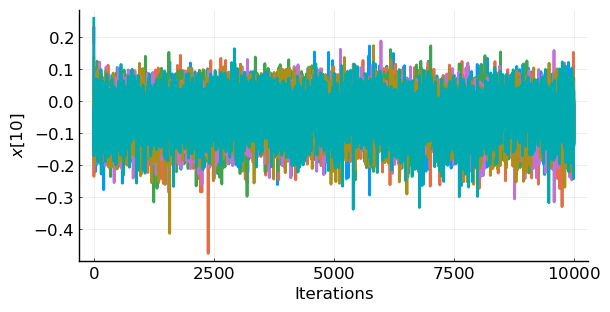

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/deblurring_model4_traces_x10_original_Gibbs_prior.pdf"

In [37]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    1:thin:nr_samples_raw, x_original_j1, 
    lw=2, 
    legend=false, 
    xlabel="Iterations", ylabel=L"x[10]",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/deblurring_model$(model_nr)_traces_x10_original_Gibbs_$(init).pdf")
savefig(output_filename)

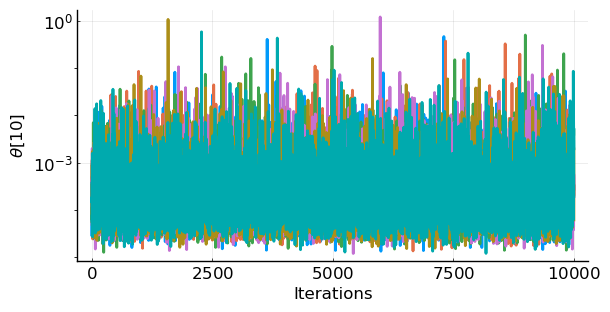

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/deblurring_model4_traces_theta10_original_Gibbs_prior.pdf"

In [38]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    1:thin:nr_samples_raw, θ_original_j1, 
    yscale=:log10, 
    lw=2, 
    legend=false, 
    xlabel="Iterations", ylabel=L"θ[10]",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/deblurring_model$(model_nr)_traces_theta10_original_Gibbs_$(init).pdf")
savefig(output_filename)

### Consider $x[j]$ and $\theta[j]$ for $j=22$. 

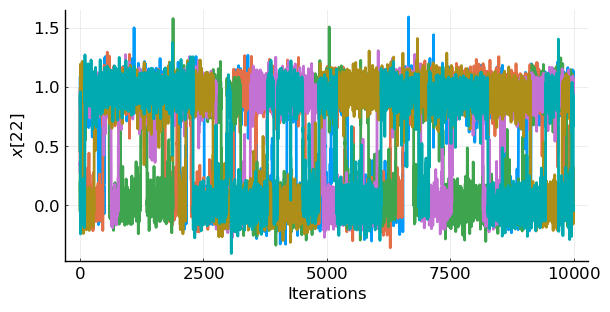

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/deblurring_model4_traces_x22_original_Gibbs_prior.pdf"

In [39]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    1:thin:nr_samples_raw, x_original_j2, 
    lw=2, 
    legend=false, 
    xlabel="Iterations", ylabel=L"x[22]",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/deblurring_model$(model_nr)_traces_x22_original_Gibbs_$(init).pdf")
savefig(output_filename)

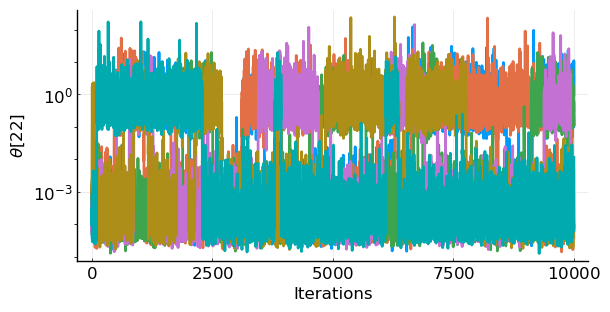

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/deblurring_model4_traces_theta22_original_Gibbs_prior.pdf"

In [40]:
# Generate figure
Plots.pyplot()

# Create the traceplot
p = StatsPlots.plot(
    1:thin:nr_samples_raw, θ_original_j2, 
    yscale=:log10, 
    lw=2, 
    legend=false, 
    xlabel="Iterations", ylabel=L"θ[22]",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, 
    "figures/deblurring_model$(model_nr)_traces_theta22_original_Gibbs_$(init).pdf")
savefig(output_filename)